# Imports

In [1]:
import datetime

import ta
import gym
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from gym import spaces
from pylab import rcParams
from pandas import read_csv
from matplotlib import pyplot as plt

from stable_baselines import A2C
from stable_baselines.common import set_global_seeds
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy

# Constants

In [2]:
STOCK_DIRECTORY = "./StockData/"  # Where should the system obtain the stock data from?
TRAINING_STOCK = "AMZN"  # Which stock file should be used for training?
TESTING_STOCK = "BTC"  # Which stock file should be used for testing?

INIT_INVEST = 25.0

SEED = 256  # Seed of the model
NO_ENTRIES_TAKING_AVG = 10  # No. entries to consider when taking average

NO_ITERATIONS = 100000  # Number of iterations to train the A2C agent on?
MAX_TRADING_SESSION = 500  # How many entries, maximally, can the environment take as data?

USE_TENSORBOARD = False  # Should it use tensorboard?
IS_JUPYTER = True  # Is this run in a Jupyter notebook?

# Setup

In [3]:
# Graph setup
def setup_graph(jupyter=False, render=False):
    # For Jupyter notebook
    if jupyter:
        if render:
            %matplotlib notebook
        
        else:
            %matplotlib inline
    
    if not render:
        rcParams['figure.figsize'] = 14, 8
    
    # Setup Seaborn style
    sns.set(style='white', palette='muted', font_scale=1.5)

setup_graph(jupyter=IS_JUPYTER)

# Seeding setup
set_global_seeds(SEED)

# Tensorboard setup
if USE_TENSORBOARD:
    %load_ext tensorboard.notebook

# Data Preparation

To process the data from each subdirectory, a function called `get_data()` will handle the obtaining of data from each sub directory.

In [4]:
def get_data(stock_directory, stock_symbol):
    """
    Processes data from one subdirectory in the root directory to be parsed later for data training.
    
    Keyword Arguments:
     - stock_directory (str): Directory which contains the stock values file and the sentiment scores file
     - stock_symbol (str): The stock symbol
    """
    full_path = stock_directory + stock_symbol + "/" + stock_symbol

    # Load stock prices from the CSV file
    stock_data = read_csv(full_path + "_stocks.csv", header=0, squeeze=True)

    # Remove the "Adj Close" and "Volume" column
    stock_data = stock_data.drop(stock_data.columns[list(range(5, 7))], axis=1)
    
    # Convert stock data to np.array
    stock_arr = stock_data.values

    # Load sentiment data
    sentiment_data = read_csv(full_path + "_sentiments.csv", header=0, squeeze=True)

    # Convert sentiment data to np.array
    sentiment_arr = sentiment_data.values[::-1]
    
    # Fill in missing values for sentiment data
    sentiment_arr_new = sentiment_arr.copy()

    i = 0
    first_date = sentiment_arr_new[0][0]  # The literal first date

    while i < sentiment_arr_new.shape[0] - 1:
        date1 = datetime.datetime.strptime(sentiment_arr_new[i][0], "%Y-%m-%d")
        date2 = datetime.datetime.strptime(sentiment_arr_new[i + 1][0], "%Y-%m-%d")

        if (date2 - date1).total_seconds() > 60 * 60 * 24:  # More than 1 day
            no_days_separation = int((date2 - date1).total_seconds() / (60 * 60 * 24))
            difference_per_day = (sentiment_arr_new[i + 1][1] - sentiment_arr_new[i][1]) / no_days_separation

            for day in range(1, no_days_separation):
                sentiment_arr_new = np.insert(sentiment_arr_new, i + day, [datetime.datetime.strftime(date1 + datetime.timedelta(days=day), "%Y-%m-%d"), sentiment_arr_new[i][1] + day * difference_per_day], axis=0)

            i+= no_days_separation - 1
        i += 1

    sentiment_arr = sentiment_arr_new[:-1]
    
    # Fill in missing values for stock data
    stock_arr_new = list(stock_arr)

    i = 0
    first_date_processed = datetime.datetime.strptime(first_date, "%Y-%m-%d")
    first_surpassed_index = -1
    while i < len(stock_arr_new[:-1]):
        date1 = datetime.datetime.strptime(stock_arr_new[i][0], "%Y-%m-%d")

        if date1 >= first_date_processed:
            if first_surpassed_index == -1:
                first_surpassed_index = i

            date2 = datetime.datetime.strptime(stock_arr_new[i+1][0], "%Y-%m-%d")

            if (date2 - date1).total_seconds() > 60 * 60 * 24:  # More than 1 day
                no_days_separation = int((date2 - date1).total_seconds() / (60 * 60 * 24))
                
                difference_open = (stock_arr_new[i + 1][1] - stock_arr_new[i][1]) / no_days_separation
                difference_high = (stock_arr_new[i + 1][2] - stock_arr_new[i][2]) / no_days_separation
                difference_low = (stock_arr_new[i + 1][3] - stock_arr_new[i][3]) / no_days_separation
                difference_close = (stock_arr_new[i + 1][4] - stock_arr_new[i][4]) / no_days_separation

                for day in range(1, no_days_separation):
                    stock_arr_new.insert(i + day, [datetime.datetime.strftime(date1 + datetime.timedelta(days=day), "%Y-%m-%d"), 
                                                   stock_arr_new[i][1] + day * difference_open,
                                                   stock_arr_new[i][2] + day * difference_high,
                                                   stock_arr_new[i][3] + day * difference_low,
                                                   stock_arr_new[i][4] + day * difference_close])

                i += no_days_separation - 1
        i += 1

    stock_arr = np.array(stock_arr_new[first_surpassed_index:-1], dtype=object)
    
    # Clear memory
    del stock_arr_new, sentiment_arr_new, first_date_processed, i, first_date, first_surpassed_index
    
    # Make both start on same day
    if sentiment_arr[0][0] != stock_arr[0][0]:
        if sentiment_arr[0][0] < stock_arr[0][0]:
            while True:
                sentiment_arr = np.delete(sentiment_arr, 0, axis=0)

                if sentiment_arr[0][0] == stock_arr[0][0]:
                    break

        else:  # Must be larger
            while True:
                stock_arr = np.delete(stock_arr, 0, axis=0)

                if sentiment_arr[0][0] == stock_arr[0][0]:
                    break
    
    # Make both end on same day
    if sentiment_arr[-1][0] != stock_arr[-1][0]:
        if sentiment_arr[-1][0] < stock_arr[-1][0]:        
            while True:
                stock_arr = np.delete(stock_arr, stock_arr.shape[0]-1, axis=0)
                if sentiment_arr[sentiment_arr.shape[0] - 1][0] == stock_arr[stock_arr.shape[0] - 1][0]:
                    break

        else:  # Must be larger
            while True:
                sentiment_arr = np.delete(sentiment_arr, sentiment_arr.shape[0] - 1, axis=0)
                if sentiment_arr[sentiment_arr.shape[0] - 1][0] == stock_arr[stock_arr.shape[0] - 1][0]:
                    break
                    
    # Join the two separate arrays into one single array
    data_arr = []
    for i in range(stock_arr.shape[0]):  # Should have same shape
        data_arr.append([stock_arr[i][0], stock_arr[i][1], stock_arr[i][2], stock_arr[i][3], stock_arr[i][4], sentiment_arr[i][1]])  # The format is: DATE, OPEN, HIGH, LOW, CLOSE, SENTIMENT_VAL

    return np.array(data_arr, dtype=object)


# Preprocessing

To save time and effort for future preprocessings, we create a universal function `prep_data()` to load and prepare the data required for training. `prep_data()` will take the source directory as input, and will output a dataframe as the output.

In [5]:
def prep_data(stock_directory, stock_symbol):
    """
    Preprocesses data from the directory for training.
    
    Keyword Arguments:
     - stock_directory (str): Directory which contains the stock values file and the sentiment scores file
     - stock_symbol (str): The stock symbol
    """
    def normalise(xi, xmin, xmax, p=0, q=1):
        """
        Normalises the data to be in the range p to q.
        """
        return (((q - p) * (xi - xmin)) / (xmax - xmin)) + p
    
    def moving_avg(arr, index, i_val, no_entries_taking_avg):
        """
        Computes the moving average list given an array `arr`.
        """
        return sum([x[index] for x in arr[i_val - no_entries_taking_avg:i_val]]) / no_entries_taking_avg
    
    # Get the data
    dl = get_data(stock_directory, stock_symbol)
    
    # Take moving average of both the stock values and the sentiment values
    avged = []

    for i in range(NO_ENTRIES_TAKING_AVG, len(dl)):  # Remove `NO_ENTRIES_TAKING_AVG` entries from the datalist
        avged.append([moving_avg(dl, 1, i, NO_ENTRIES_TAKING_AVG),
                      moving_avg(dl, 2, i, NO_ENTRIES_TAKING_AVG),
                      moving_avg(dl, 3, i, NO_ENTRIES_TAKING_AVG),
                      moving_avg(dl, 4, i, NO_ENTRIES_TAKING_AVG),
                      moving_avg(dl, 5, i, NO_ENTRIES_TAKING_AVG),
                     ])
    
    # Find min and max from stocks
    min_val = float("inf")
    max_val = -float("inf")

    for entry in avged:
        # Check for stock values only
        min_val = min(min_val, min(entry[0], min(entry[1], min(entry[2], entry[3]))))
        max_val = max(max_val, max(entry[0], max(entry[1], max(entry[2], entry[3]))))

    # Normalise the stocks' values
    normed = []

    for entry in avged:
        normed.append([normalise(entry[0], min_val, max_val, p=1, q=10),
                       normalise(entry[1], min_val, max_val, p=1, q=10),
                       normalise(entry[2], min_val, max_val, p=1, q=10),
                       normalise(entry[3], min_val, max_val, p=1, q=10),
                       entry[4]])
    
    # Convert `avged` to a pandas dataframe
    df_dict = {"Open": [], "High": [], "Low": [], "Close": [], "Sentiment": []}
    
    for i in range(len(avged)):
        df_dict["Open"].append(normed[i][0])
        df_dict["High"].append(normed[i][1])
        df_dict["Low"].append(normed[i][2])
        df_dict["Close"].append(normed[i][3])
        df_dict["Sentiment"].append(normed[i][4])
        
    df = pd.DataFrame(df_dict)
    
    return df


In [6]:
trainingDF = prep_data(STOCK_DIRECTORY, TRAINING_STOCK)

Let's see what our `trainingDF` looks like.

In [7]:
print(trainingDF)

         Open      High       Low     Close  Sentiment
0    1.056241  1.222210  1.000000  1.191314   0.557003
1    1.166698  1.345495  1.101761  1.305648   0.548523
2    1.272285  1.466701  1.190343  1.413780   0.554255
3    1.377751  1.582553  1.278231  1.499665   0.574197
4    1.490286  1.699046  1.363155  1.578758   0.579474
5    1.583647  1.777108  1.426820  1.639984   0.570086
6    1.649303  1.835479  1.485724  1.692611   0.546033
7    1.711730  1.896286  1.543766  1.740060   0.507314
8    1.781869  1.968215  1.608327  1.798023   0.463614
9    1.829877  2.020177  1.652487  1.843025   0.414933
10   1.856819  2.044751  1.678851  1.868075   0.388590
11   1.916071  2.102074  1.745949  1.933136   0.372082
12   2.002885  2.176069  1.808438  1.992595   0.365410
13   2.067921  2.229256  1.887800  2.075308   0.368572
14   2.146107  2.300169  1.988193  2.185422   0.381569
15   2.242969  2.411371  2.108900  2.312610   0.395184
16   2.367038  2.544122  2.233426  2.447604   0.409416
17   2.477

If we want to convert `trainingDF` into a `np.ndarray`, we can simply do:

In [8]:
trainingData = trainingDF.values
print(trainingData)

[[1.05624095 1.22221035 1.         1.19131407 0.5570025 ]
 [1.16669759 1.34549516 1.10176106 1.30564837 0.54852321]
 [1.27228532 1.46670093 1.1903428  1.41377962 0.55425464]
 ...
 [6.95883184 7.05324241 6.77996847 6.91064605 0.2485375 ]
 [6.91845255 7.00816139 6.73361838 6.87407354 0.267155  ]
 [6.88488624 6.98749596 6.72352739 6.87632059 0.311915  ]]


Now, let's see the graphs of the stock data and the sentiment data.

Stock values:

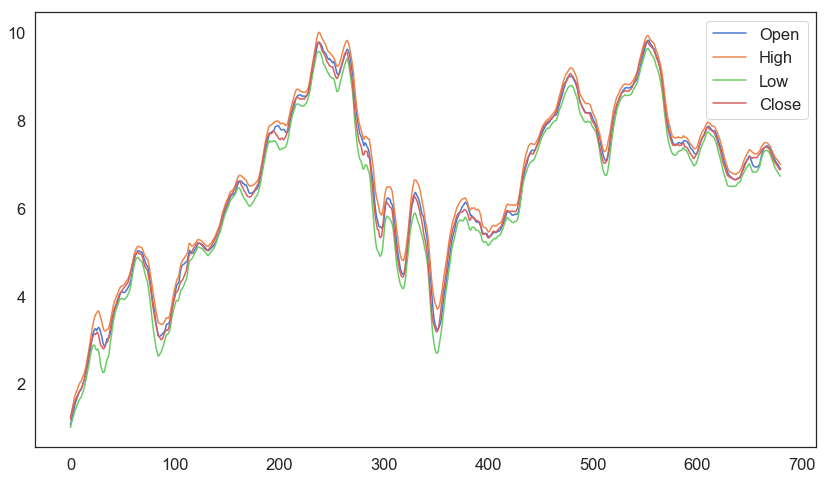

In [9]:
plt.plot(range(len(trainingData)), [st[0] for st in trainingData], label="Open")
plt.plot(range(len(trainingData)), [st[1] for st in trainingData], label="High")
plt.plot(range(len(trainingData)), [st[2] for st in trainingData], label="Low")
plt.plot(range(len(trainingData)), [st[3] for st in trainingData], label="Close")

plt.legend(loc="best")

The Sentiment Data:

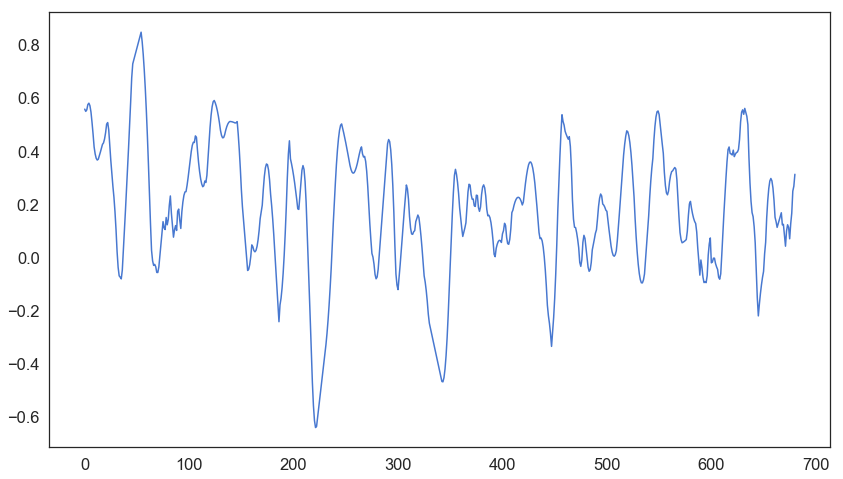

In [10]:
plt.plot(range(len(trainingData)), [st[4] for st in trainingData])

# Building the environment

**Observation State**: [# of stock owned, open history, high history, low history, close history, 
                        sentiment history, cash in hand history, net worth history]

**Action Space**: 
- 3 Actions: Sell [0], Hold [1], Buy [2]
- 10 Amounts: 1/10 of total, 2/10 of total, 3/10 of total etc.

In [11]:
class TradingEnv(gym.Env):
    """
    The trading environment.
  
    Observation State: [# of stock owned, open history, high history, low history, close history, 
                        sentiment history, cash in hand history, net worth history]

    Action Space: 
    - 3 Actions: Sell [0], Hold [1], Buy [2]
    - 10 Amounts: 1/10 of total, 2/10 of total, 3/10 of total etc.
    """
    metadata = {'render.modes': ['human', 'system', 'none']}
    viewer = None

    def __init__(self, data_df, init_invest=25.0, reward_len=32, lookback_window_size=5, is_serial=False, reward_function="Difference", forecast_length=5):
        """
        Initialization function for the trading environment.
        
        Keyword arguments:
        - data_df, pd.DataFrame: A pandas dataframe containing all the data.
        - init_invest, Float: Starting cash (Default = 5.0)
        - reward_len, Integer: No of entries to consider when calculating reward (Default = 32)
        - lookback_window_size, Integer: How many entries can the agent look back? (Default = 5)
        - is_serial, bool: Is the environment serial (i.e. following a strict sequence)? (Default = False)
        - reward_function, string: What reward function to use? Must be in the list [Difference"]. (Default = "Difference")
        - forecast_length, int: How many entries to forecast? (Default = 5)
        """
        # Assert reward function parameter is defined
        assert reward_function in ["Difference"], "Reward function not in the list [Difference]"
        
        # Convert given data into variables
        self.data_df = data_df  # This is the dataframe where all the data is stored
        self.full_data_arr = self.data_df.values  # All the values, converted into a np.array
        self.init_invest = init_invest  # Initial investment value
        self.reward_len = reward_len  # Length of reward consideration array
        self.lookback_window = lookback_window_size  # Size of the lookback window
        self.is_serial = is_serial  # Is the environment serial?
        self.reward_function = reward_function  # The reward function
        self.forecast_len = forecast_length  # The forecast length
        
        # Create the histories
        self.open_history = [x[0] for x in self.full_data_arr]  # All the `Open` values for the stock
        self.high_history = [x[1] for x in self.full_data_arr]  # All the `High` values for the stock
        self.low_history = [x[2] for x in self.full_data_arr]  # All the `Low` values for the stock
        self.close_history = [x[3] for x in self.full_data_arr]  # All the `Close` values for the stock
        self.sentiment_history = [x[4] for x in self.full_data_arr]  # This is the normalised sentiment data
        
        # Create data_arr
        self.total_len = len(self.data_df)
        self.cur_len = None
        
        self.start_index = None
        self.end_index = None
        
        self.data_arr = None
        self.generate_data_arr(is_serial)

        # Instance attributes
        self.cur_step = self.start_index
        self.stock_owned = None
        self.cash_in_hand = None
        self.done = False  # TODO: REMOVE
        self.actions_taken = []
        self.actions_amounts = []
        
        # Observation space variables
        self.net_worths = None
        self.stock_owned_history = None
        self.cash_in_hand_history = None

        # Action space
        self.action_space = spaces.MultiDiscrete([3, 10]) 
        
        # Observation space: give estimates in order to sample and build scaler
        stock_max = max(max(self.open_history), max(max(self.high_history), max(max(self.low_history), max(self.close_history))))
        
        # TODO: FIX OBSERVATION SPACE DEFINITION BELOW, IF NEEDED
        self.observation_space = spaces.Box(low=-1, high=init_invest * 3 * (1 + (1 // stock_max)), shape=(8, self.lookback_window), dtype=np.float32)
        
        # Rendering variables
        self.fig = None
        self.net_worth_ax = None
        self.net_worth_annotation = None
        self.net_worth_line = None
        self.stock_ax = None
        self.stock_line = None
        self.stock_annotation = None
        
        # Reset env and start
        self.reset()
        
    def generate_data_arr(self, serial):
        """
        Generates the new data_arr.
        
        Keyword arguments:
        - serial, bool: Is the environment serial (i.e. following a strict sequence)?
        """
        
        if serial:  # No need to randomise the start and end positions
            # Use all of the data_df values
            self.start_index = self.lookback_window
            self.end_index = self.total_len - 1
            
            self.cur_len = self.end_index - self.start_index
        
        else:
            # Generate a random range for training
            local_max_trading_session = min(MAX_TRADING_SESSION, self.total_len)  # We won't want it exceeding, now would we?
            
            self.cur_len = np.random.randint(self.lookback_window, local_max_trading_session) - self.lookback_window - 1
            self.start_index = np.random.randint(self.lookback_window, self.total_len - self.cur_len)
            self.end_index = self.start_index + self.cur_len
            
        self.data_arr = self.data_df.values[self.start_index: self.end_index]

    def reset(self):
        """
        Resets the environment.
        """
        # Create new active array
        self.generate_data_arr(self.is_serial)
        
        # Reset all needed variables
        self.cur_step = self.start_index  # Step reset to 0
        self.stock_owned = 0.
        self.cash_in_hand = self.init_invest
        self.actions_taken = []
        self.actions_amounts = []
        
        self.net_worths = [self.init_invest] * self.lookback_window
        self.stock_owned_history = [0] * self.lookback_window
        self.cash_in_hand_history = [self.init_invest] * self.lookback_window
        
        self.fig = None
        self.net_worth_ax = None
        self.net_worth_annotation = None
        self.net_worth_line = None
        self.stock_ax = None
        self.stock_line = None
        self.stock_annotation = None
        
        # Clear figure
        plt.clf()
        
        return self.get_obs()

    def step(self, action):
        """
        Moves forward one step in time.
        
        Keyword arguments:
        - action: Action to be taken. (Integer)
        
        Returns:
        - Observation space (List)
        - reward: Reward for taking the action (Float)
        - done: Whether the environment has completed its cycle (Boolean Value)
        - info: Useful info (String)
        """
        # Move forward one day in time
        self.cur_step += 1
        self.trade(action)
        
        # What's changed?
        self.net_worths.append(self.get_val())  # Current net worth
        
        # Generate reward
        reward = self.gen_reward()
        
        # Update info
        info = {'cur_val': self.net_worths[-1]}
        
        return self.get_obs(), reward, self.done, info

    def get_obs(self):
        """
        Gets the observation list.
        
        Returns:
        - Observation list (List)
        """
        return np.array([self.stock_owned_history[-self.lookback_window:], 
                         self.open_history[self.cur_step-self.lookback_window: self.cur_step], 
                         self.high_history[self.cur_step-self.lookback_window: self.cur_step],
                         self.low_history[self.cur_step-self.lookback_window: self.cur_step],
                         self.close_history[self.cur_step-self.lookback_window: self.cur_step],
                         self.sentiment_history[self.cur_step-self.lookback_window: self.cur_step], 
                         self.cash_in_hand_history[-self.lookback_window:],
                         self.net_worths[-self.lookback_window:]])

    def get_val(self):
        """
        Calculates the current portfolio value of the Agent.
        
        Returns:
        - Portfolio value (Float)
        """
        return self.stock_owned * self.close_history[self.cur_step] + self.cash_in_hand
    
    def gen_reward(self):
        """
        Generates the reward based on the reward function defined.
        """
        reward = None
        
        """
        REWARD FUNCTION: Difference
        Take current net worth - previous net worth.
        """
        reward = self.net_worths[-1] - self.net_worths[-2]
        
        return reward if np.isfinite(reward) else 0

    def trade(self, action):
        """
        Helper function to "trade" the stocks
        
        Keyword arguments:
        - action: Action to take (Integer)
        """
        # Check if done
        self.done = self.cur_step >= self.end_index  # Only will be done if the current step is the ending step (in zero based indexing)
        
        # Split Action type and Amount
        action_type = action[0]
        action_amount = action[1] / 10  # Representing 1/10, 2/10, 3/10 etc.
        
        if action_type == 0:  # Sell
            stock_sold = int(self.stock_owned * action_amount)  # We won't want partial stocks, now do we?
            
            self.cash_in_hand += self.open_history[self.cur_step] * stock_sold
            self.stock_owned -= stock_sold
        
        elif action_type == 1:  # Hold
            # Nothing to do here, move on.
            pass
        
        elif action_type == 2:  # Buy
            stock_bought = int((self.cash_in_hand / self.open_history[self.cur_step]) * action_amount)  # We won't want partial stocks, now do we?
            
            self.cash_in_hand -= self.open_history[self.cur_step] * stock_bought
            self.stock_owned += stock_bought
        
        # Append new cash in hand to cash_in_hand_history
        self.cash_in_hand_history.append(self.cash_in_hand)
        
        # Append new stock quantity to stock_owned_history
        self.stock_owned_history.append(self.stock_owned)
        
        # Append action type taken to actions_taken
        self.actions_taken.append(action[0])
        
        # Append action amount to actions_amounts
        self.actions_amounts.append(action[1] / 10 if action[0] == 2 else (-action[1] / 10 if action[0] == 0 else 0))  # Negative values = Selling
    
    def render(self, mode="human"):
        if mode == "human":
            if self.cur_step == self.start_index + 1:
                # Render setup
                setup_graph(jupyter=IS_JUPYTER, render=True)
                
                # Set up axes
                self.fig, (self.net_worth_ax, self.stock_ax) = plt.subplots(2, sharex=True)  # 2 Horizontally stacked subplots with shared axes
                
                # Update axes titles
                self.net_worth_ax.title.set_text("Net Worth")
                self.stock_ax.title.set_text("Stock Price")
                
                # Set the scales
                self.net_worth_ax.set_xlim([self.start_index - 1, self.end_index])  # This is a known limit
                
                # Set up dummy variables
                self.net_worth_line, = self.net_worth_ax.plot(np.linspace(0, 0, self.cur_len), np.linspace(0, 0, self.cur_len), color="b")  # Create a line with the correct space
                self.net_worth_annotation = self.net_worth_ax.text(0, 0, "0", bbox=dict(boxstyle='round', fc='w', ec='k', lw=1))
                
                self.stock_line, = self.stock_ax.plot(np.linspace(0, 0, self.cur_len), np.linspace(0, 0, self.cur_len), color="r")
                self.stock_annotation = self.stock_ax.text(0, 0, "0", bbox=dict(boxstyle='round', fc='w', ec='k', lw=1))
                             
            # Update data of the net worth line
            self.net_worth_line.set_xdata(range(self.start_index, self.cur_step))
            self.net_worth_line.set_ydata(self.net_worths[:self.cur_step - self.start_index])
            
            # Update data of the stock line
            self.stock_line.set_xdata(range(self.start_index, self.cur_step))
            self.stock_line.set_ydata(self.close_history[self.start_index:self.cur_step])
            
            # Annotate the current net worth of the agent
            self.net_worth_annotation.set_text("{0:.2f}".format(self.net_worths[-1]))
            self.net_worth_annotation.set_x(self.cur_step)
            self.net_worth_annotation.set_y(self.net_worths[-1])
            
            # Annotate the current stock price
            self.stock_annotation.set_text("{0:.2f}".format(self.close_history[self.cur_step]))
            self.stock_annotation.set_x(self.cur_step)
            self.stock_annotation.set_y(self.close_history[self.cur_step])
            
            # Adjust the scale of the axes
            line_min_networth = min(self.net_worths)
            line_max_networth = max(self.net_worths)
            adjustment_networth = line_max_networth * 0.1
            self.net_worth_ax.set_ylim([line_min_networth - adjustment_networth, line_max_networth + adjustment_networth])
            
            line_min_stock = min(self.close_history[self.start_index:self.cur_step])
            line_max_stock = max(self.close_history[self.start_index:self.cur_step])
            adjustment_stock = line_max_stock * 0.1
            self.stock_ax.set_ylim([line_min_stock - adjustment_stock, line_max_stock + adjustment_stock])

            # Update canvas
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
            
            if self.done is True:
                # Reset back to normal
                setup_graph(jupyter=IS_JUPYTER)
                
                # Redraw graph in enlarged form
                fig, (net_worth_ax, stock_ax, amount_ax) = plt.subplots(3, sharex=True)
                
                # Update axes titles
                net_worth_ax.title.set_text("Net Worth: {0:.2f}".format(self.net_worths[-1]))
                stock_ax.title.set_text("Stock Price: {0:.2f}".format(self.close_history[self.cur_step]))
                amount_ax.title.set_text("Amount Bought/Sold (-1 to 1)")
                
                # Set the scales
                net_worth_ax.set_xlim([self.start_index - 1, self.end_index])
                
                net_worth_ax.set_ylim([line_min_networth - adjustment_networth, line_max_networth + adjustment_networth])
                stock_ax.set_ylim([line_min_stock - adjustment_stock, line_max_stock + adjustment_stock])
                amount_ax.set_ylim([-1.1, 1.1])
                
                # Draw lines
                net_worth_ax.plot(range(self.start_index, self.end_index), self.net_worths[:self.cur_len], color="b", label="Net Worth")
                stock_ax.plot(range(self.start_index, self.end_index), self.close_history[self.start_index: self.end_index], color="r", label="Closing Price")
                
                # Process actions taken
                sell_only = [1 if x == 0 else 0 for x in self.actions_taken]
                buy_only = [1 if x == 2 else 0 for x in self.actions_taken]
                
                sell_actions = [x if x < 0 else None for x in self.actions_amounts]
                buy_actions = [x if x > 0 else None for x in self.actions_amounts]
                
                # Plot actions taken
                net_worth_ax.scatter(range(self.start_index, self.end_index), [sell_only[i] * self.net_worths[i] for i in range(self.cur_len)], label="Sell", color="red", marker="x")
                net_worth_ax.scatter(range(self.start_index, self.end_index), [buy_only[i] * self.net_worths[i] for i in range(self.cur_len)], label="Buy", color="green", marker="x")
                
                stock_ax.scatter(range(self.start_index, self.end_index), [sell_only[i - self.start_index] * self.close_history[i] for i in range(self.start_index, self.end_index)], label="Sell", color="red", marker="x")
                stock_ax.scatter(range(self.start_index, self.end_index), [buy_only[i - self.start_index] * self.close_history[i] for i in range(self.start_index, self.end_index)], label="Buy", color="green", marker="x")
                
                amount_ax.stem(range(self.start_index, self.end_index), sell_actions, "red", markerfmt="ro", label="Sell")
                amount_ax.stem(range(self.start_index, self.end_index), buy_actions, "green", markerfmt="go", label="Buy")
                
                # Legend
                net_worth_ax.legend(loc="best")
                stock_ax.legend(loc="best")
                amount_ax.legend(loc="best")
                plt.show()
                

# Baseline Creation

A baseline is a function/algorithm which has a known value for its success. If our model does worse than our baseline, then it would be "bad".

Let's use three different baselines:
- Buy and Hold On for Dear Life (BHODL)
- Relative Strength Index (RSI) Divergence
- Simple Moving Average (SMA) Crossover

We create the class `Baselines` to house all three algorithms.

In [12]:
class Baselines:
    def __init__(self, dataframe, render=True):
        """
        Baselines class. Contains the 3 baselines' policies.
        
        Keyword argument:
        - dataframe, pd.DataFrame: The dataframe containing all the data needed to train our model
        - render, Boolean: To render the environment or not (Default = True)
        """
        self.dataframe = dataframe  # Our dataframe
        self.render = render  # Can render?
        
        self.env = TradingEnv(self.dataframe, init_invest=INIT_INVEST, is_serial=True)
    
    def run_policies(self):
        """
        Run the baselines' policies against an environment.
        
        Returns:
        - Scores of the three baselines in a list in the form [BHODL Score, RSI Score, SMA Score].
        """
        
        def bhodl_policy():
            """
            An old trading statagy, BHODL can be used as our first baseline against our model.

            It is a realitively simple baseline to program:
            - If can buy, buy.
            - Else, hold.

            In principle, BHODL buys as much stock it can before bankrupting, and holds it to the end of the training period.
            """
            if self.env.cash_in_hand // self.env.open_history[self.env.cur_step] >= 1:  # More than enough to buy at least one stock
                return [2, 10]

            # If not, hold for all other cases
            else:
                return [1, 10]  # Amount doesn't matter


        def rsi_policy():
            """
            When consecutive closing price continues to rise as the Relitive Strength Index (RSI) continues to drop, 
            a negative trend reversal (aka a sell) is signaled. A positive trend reversal (aka buy) is signaled when 
            closing price consecutively drops as the RSI consecutively rises.
            """
            period = 5
            prices = pd.DataFrame(self.env.close_history)[0]
            i = self.env.cur_step

            rsi = ta.rsi(prices)

            if i >= period:
                rsiSum = sum(rsi[i - period:i + 1].diff().cumsum().fillna(0))
                priceSum = sum(prices[i - period:i + 1].diff().cumsum().fillna(0))

                if rsiSum < 0 and priceSum >= 0:
                    return [0, 10]
                elif rsiSum > 0 and priceSum <= 0:
                    return [2, 10]

            return [1, 10]

        def sma_policy():
            """
            When the longer-term SMA crosses above the shorter-term SMA, a negative trend reversal (aka sell) is 
            signaled. A positive trend reversal (aka buy) is signaled when the shorter-term SMA crosses above the 
            longer-term SMA.
            """
            prices = pd.DataFrame(self.env.close_history)[0]
            i = self.env.cur_step

            macd = ta.macd(prices)

            if macd[i] > 0 and macd[i - 1] <= 0:
                return [0, 10]

            elif macd[i] < 0 and macd[i - 1] >= 0:
                return [2, 10]

            return [1, 10]
        
        policy_order = [bhodl_policy, rsi_policy, sma_policy]
        policy_names = ["BHODL", "RSI Divergence", "SMA Crossover"]
        policy_scores = []
        
        for i, policy in enumerate(policy_order):
            done = False
            state = self.env.reset()
            
            if self.render is not True:
                runningList = tqdm(range(self.env.start_index, self.env.end_index), desc="Running {} baseline".format(policy_names[i]))
            else:
                runningList = range(self.env.start_index, self.env.end_index)

            for j in runningList:
                action = policy()

                state, _, done, _ = self.env.step(action)

                if self.render:
                    self.env.render()
            
            score = self.env.get_val()
            policy_scores.append(score)
            print("Score for {} baseline: {:.3f}".format(policy_names[i], score)) 
        
        return policy_scores
        

Now, let's compute the scores for all three baselines.

<IPython.core.display.Javascript object>


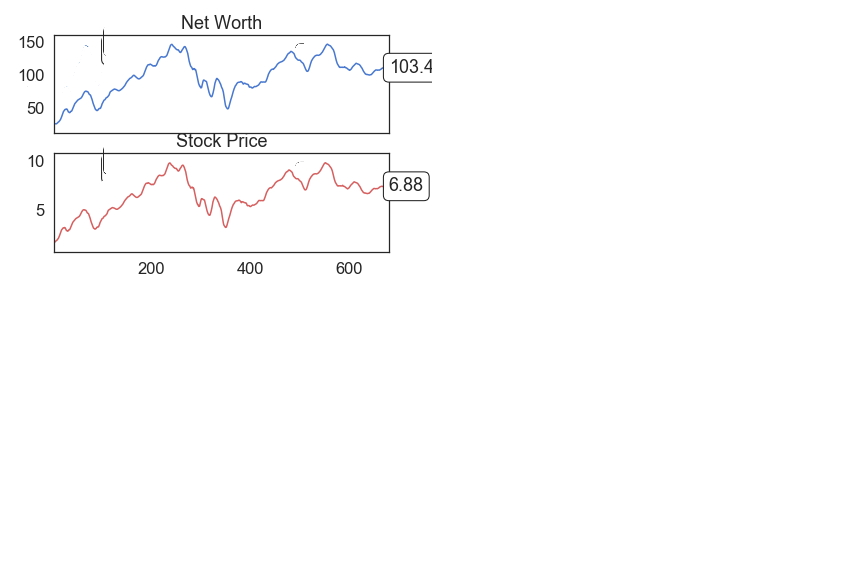

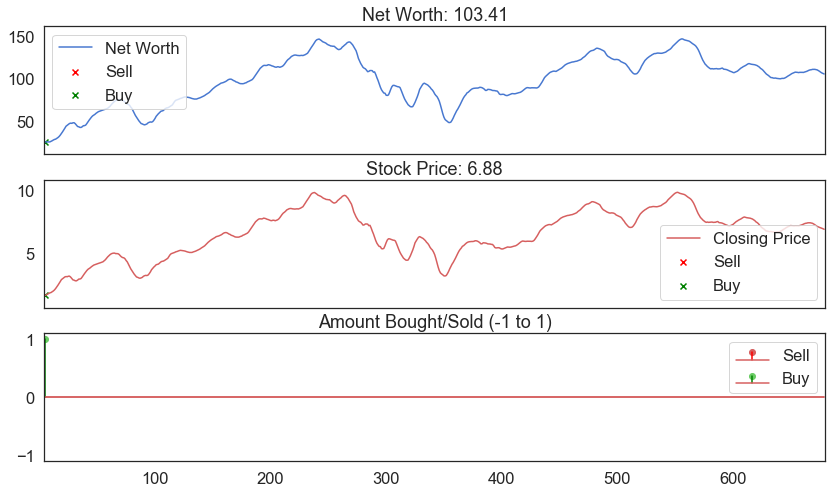

Score for BHODL baseline: 103.405


<IPython.core.display.Javascript object>


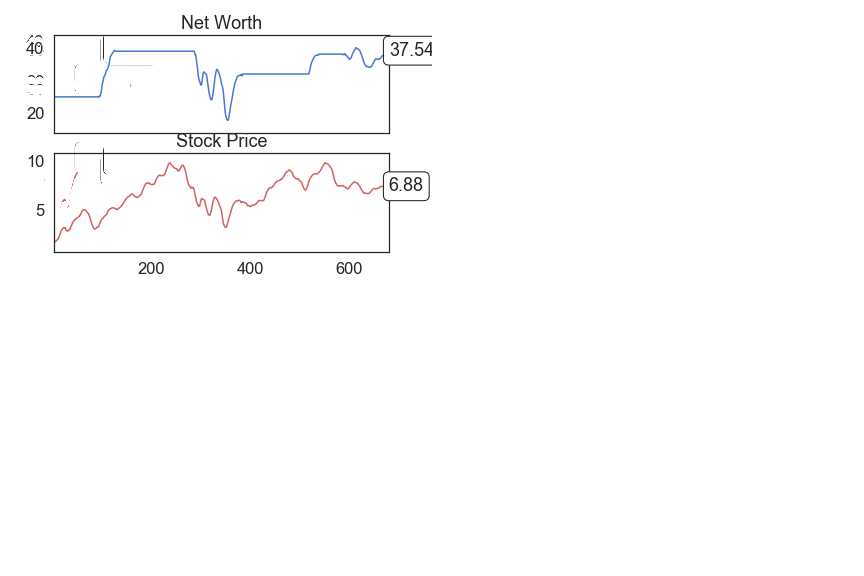

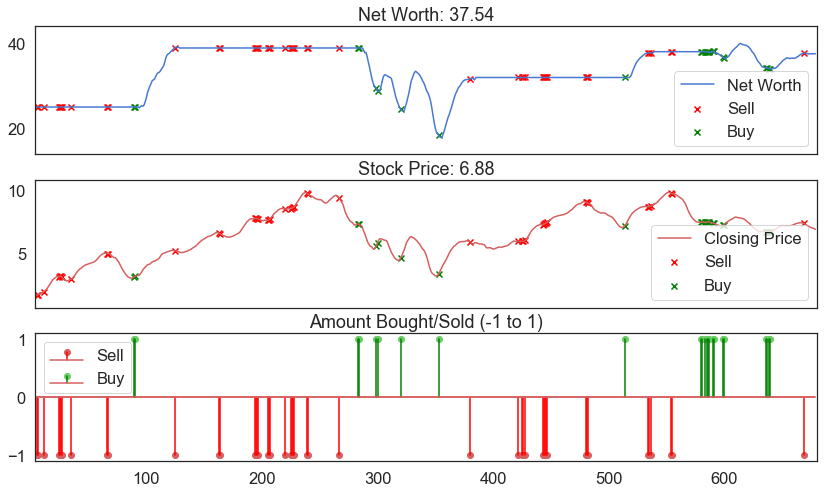

Score for RSI Divergence baseline: 37.542


<IPython.core.display.Javascript object>


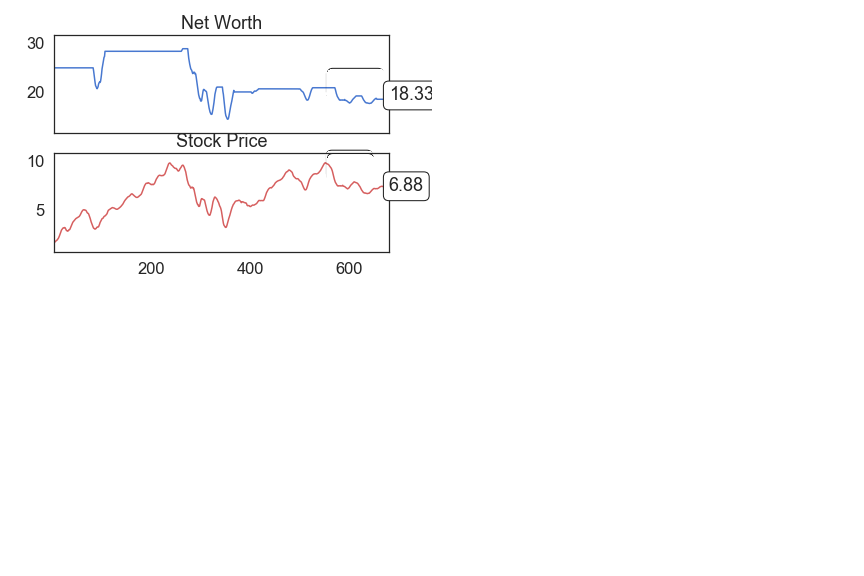

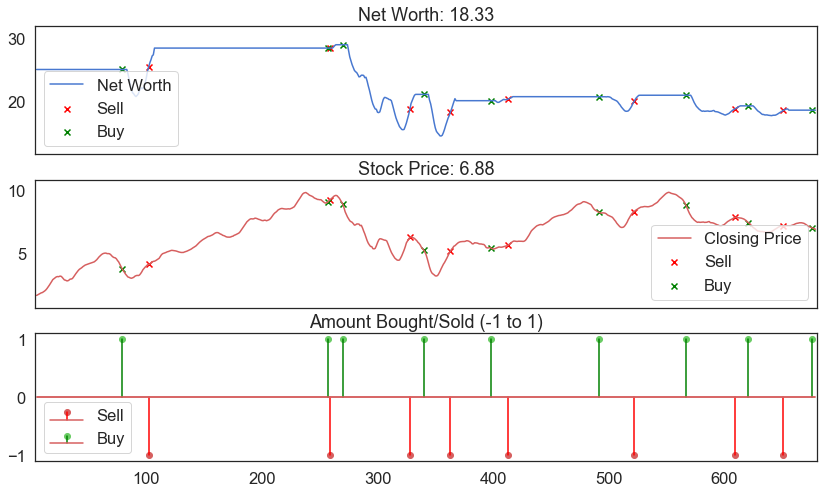

Score for SMA Crossover baseline: 18.335
[103.40526560000211, 37.54190419695771, 18.334838081621086]


In [13]:
train_baselines = Baselines(trainingDF, render=False)
train_baseline_scores = train_baselines.run_policies()

print(train_baseline_scores)

# Training the Model

Before we train the model, we need to make a training environment for the model to train on:

In [14]:
trainEnv = DummyVecEnv([lambda: TradingEnv(trainingDF, init_invest=INIT_INVEST, reward_function="Difference", is_serial=False)])

<Figure size 1008x576 with 0 Axes>

Let's now create a `A2C` model from the `stable-baselines` library:

In [15]:
model = A2C(MlpLstmPolicy, trainEnv, verbose=1, tensorboard_log="./tensorboard/A2C")

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Prepare the tensorboard for data tracking:

In [16]:
if USE_TENSORBOARD:
    %tensorboard --logdir "tensorboard/A2C"

Now, let's train the A2C model!

In [17]:
model.learn(total_timesteps=NO_ITERATIONS)

---------------------------------
| explained_variance | 0.285    |
| fps                | 11       |
| nupdates           | 1        |
| policy_entropy     | 3.4      |
| total_timesteps    | 5        |
| value_loss         | 0.296    |
---------------------------------
---------------------------------
| explained_variance | 0.202    |
| fps                | 407      |
| nupdates           | 100      |
| policy_entropy     | 3.4      |
| total_timesteps    | 500      |
| value_loss         | 0.00287  |
---------------------------------
---------------------------------
| explained_variance | 0.00149  |
| fps                | 496      |
| nupdates           | 200      |
| policy_entropy     | 3.39     |
| total_timesteps    | 1000     |
| value_loss         | 2.8      |
---------------------------------
---------------------------------
| explained_variance | -0.0284  |
| fps                | 528      |
| nupdates           | 300      |
| policy_entropy     | 3.39     |
| total_timest

---------------------------------
| explained_variance | -0.588   |
| fps                | 538      |
| nupdates           | 3100     |
| policy_entropy     | 3.22     |
| total_timesteps    | 15500    |
| value_loss         | 0.0687   |
---------------------------------
---------------------------------
| explained_variance | -0.366   |
| fps                | 537      |
| nupdates           | 3200     |
| policy_entropy     | 3.22     |
| total_timesteps    | 16000    |
| value_loss         | 0.0713   |
---------------------------------
---------------------------------
| explained_variance | -2.75    |
| fps                | 533      |
| nupdates           | 3300     |
| policy_entropy     | 3.35     |
| total_timesteps    | 16500    |
| value_loss         | 0.112    |
---------------------------------
---------------------------------
| explained_variance | -0.122   |
| fps                | 525      |
| nupdates           | 3400     |
| policy_entropy     | 3.29     |
| total_timest

---------------------------------
| explained_variance | -0.397   |
| fps                | 548      |
| nupdates           | 6200     |
| policy_entropy     | 1.3      |
| total_timesteps    | 31000    |
| value_loss         | 0.329    |
---------------------------------
---------------------------------
| explained_variance | -1.29    |
| fps                | 550      |
| nupdates           | 6300     |
| policy_entropy     | 3.08     |
| total_timesteps    | 31500    |
| value_loss         | 1.76     |
---------------------------------
---------------------------------
| explained_variance | -1.28    |
| fps                | 551      |
| nupdates           | 6400     |
| policy_entropy     | 3.16     |
| total_timesteps    | 32000    |
| value_loss         | 1.47     |
---------------------------------
---------------------------------
| explained_variance | -1.28    |
| fps                | 552      |
| nupdates           | 6500     |
| policy_entropy     | 2.13     |
| total_timest

---------------------------------
| explained_variance | -0.0273  |
| fps                | 569      |
| nupdates           | 9300     |
| policy_entropy     | 3.13     |
| total_timesteps    | 46500    |
| value_loss         | 0.259    |
---------------------------------
---------------------------------
| explained_variance | 0.241    |
| fps                | 568      |
| nupdates           | 9400     |
| policy_entropy     | 2.42     |
| total_timesteps    | 47000    |
| value_loss         | 0.286    |
---------------------------------
---------------------------------
| explained_variance | -0.702   |
| fps                | 568      |
| nupdates           | 9500     |
| policy_entropy     | 3.27     |
| total_timesteps    | 47500    |
| value_loss         | 0.00812  |
---------------------------------
---------------------------------
| explained_variance | 0.671    |
| fps                | 569      |
| nupdates           | 9600     |
| policy_entropy     | 2.67     |
| total_timest

---------------------------------
| explained_variance | -17.4    |
| fps                | 583      |
| nupdates           | 12400    |
| policy_entropy     | 3.29     |
| total_timesteps    | 62000    |
| value_loss         | 0.00611  |
---------------------------------
---------------------------------
| explained_variance | -0.808   |
| fps                | 583      |
| nupdates           | 12500    |
| policy_entropy     | 1.12     |
| total_timesteps    | 62500    |
| value_loss         | 1.49     |
---------------------------------
---------------------------------
| explained_variance | -0.0665  |
| fps                | 583      |
| nupdates           | 12600    |
| policy_entropy     | 2.59     |
| total_timesteps    | 63000    |
| value_loss         | 0.63     |
---------------------------------
---------------------------------
| explained_variance | -22.9    |
| fps                | 584      |
| nupdates           | 12700    |
| policy_entropy     | 1.48     |
| total_timest

---------------------------------
| explained_variance | 0.343    |
| fps                | 589      |
| nupdates           | 15500    |
| policy_entropy     | 2.82     |
| total_timesteps    | 77500    |
| value_loss         | 0.067    |
---------------------------------
---------------------------------
| explained_variance | -42.8    |
| fps                | 590      |
| nupdates           | 15600    |
| policy_entropy     | 3.21     |
| total_timesteps    | 78000    |
| value_loss         | 0.00848  |
---------------------------------
---------------------------------
| explained_variance | -0.299   |
| fps                | 590      |
| nupdates           | 15700    |
| policy_entropy     | 3.2      |
| total_timesteps    | 78500    |
| value_loss         | 3.36     |
---------------------------------
---------------------------------
| explained_variance | 0.309    |
| fps                | 590      |
| nupdates           | 15800    |
| policy_entropy     | 3.36     |
| total_timest

---------------------------------
| explained_variance | -0.0738  |
| fps                | 583      |
| nupdates           | 18600    |
| policy_entropy     | 3.29     |
| total_timesteps    | 93000    |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | -7.67    |
| fps                | 583      |
| nupdates           | 18700    |
| policy_entropy     | 2.6      |
| total_timesteps    | 93500    |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | -0.438   |
| fps                | 583      |
| nupdates           | 18800    |
| policy_entropy     | 1.34     |
| total_timesteps    | 94000    |
| value_loss         | 0.824    |
---------------------------------
---------------------------------
| explained_variance | -11.7    |
| fps                | 584      |
| nupdates           | 18900    |
| policy_entropy     | 3.27     |
| total_timest

<Figure size 1008x576 with 0 Axes>

Now, let's see how well the model performs on the training data:

<IPython.core.display.Javascript object>


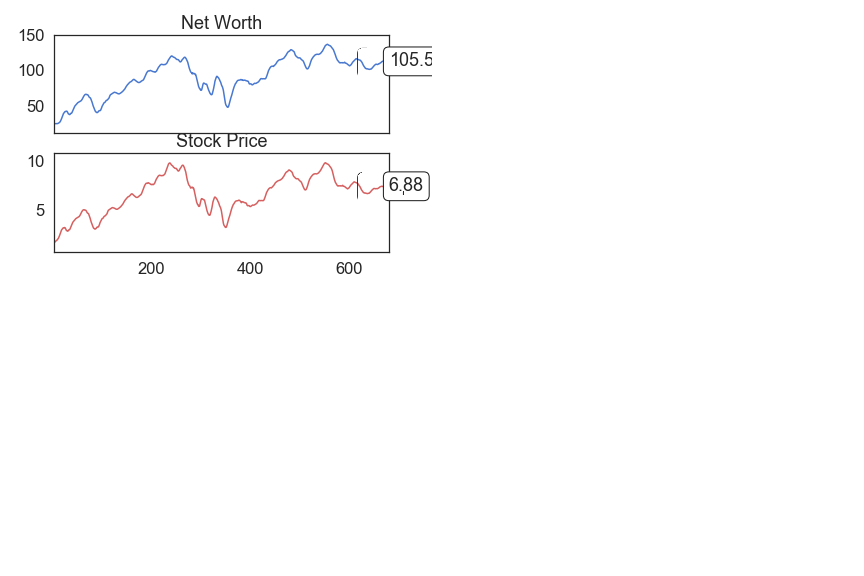

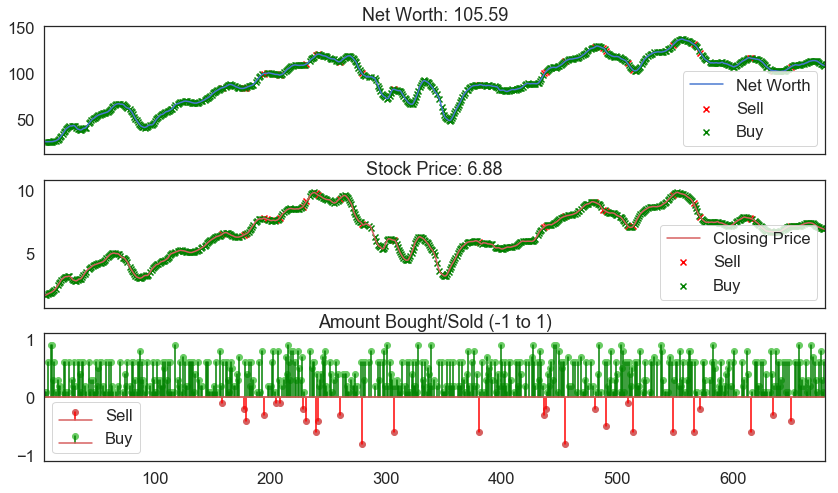

A2C Score: 105.594
A2C - BHODL = 2.189
A2C - RSI Divergence = 68.052
A2C - SMA Crossover = 87.259


In [18]:
# A2C algorithm
a2cEnv = TradingEnv(trainingDF, init_invest=INIT_INVEST, is_serial=True)  # For training purposes
done = False

state = a2cEnv.reset()

while not done:
    action, _ = model.predict([state])

    state, _, done, _ = a2cEnv.step(action[0])
    a2cEnv.render()

a2cScore = a2cEnv.get_val()  # The model's score

print("A2C Score: {:.3f}".format(a2cScore))

# Compare that to baselines
print("A2C - BHODL = {:.3f}".format(a2cScore - train_baseline_scores[0]))
print("A2C - RSI Divergence = {:.3f}".format(a2cScore - train_baseline_scores[1]))
print("A2C - SMA Crossover = {:.3f}".format(a2cScore - train_baseline_scores[2]))

# Testing the Model

Let's prep the data in the testing directory and use it to test our model.

In [19]:
testingDF = prep_data(STOCK_DIRECTORY, TESTING_STOCK)

Converting `testingDf` into a `np.ndarray`:

In [20]:
testingData = testingDF.values

The Stock Data:

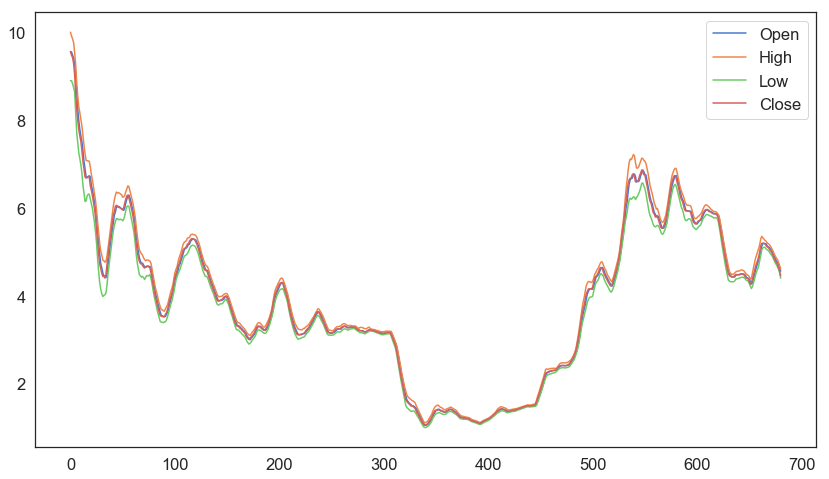

In [21]:
plt.plot(range(len(testingData)), [st[0] for st in testingData], label="Open")
plt.plot(range(len(testingData)), [st[1] for st in testingData], label="High")
plt.plot(range(len(testingData)), [st[2] for st in testingData], label="Low")
plt.plot(range(len(testingData)), [st[3] for st in testingData], label="Close")

plt.legend(loc="best")

The Sentiment Data:

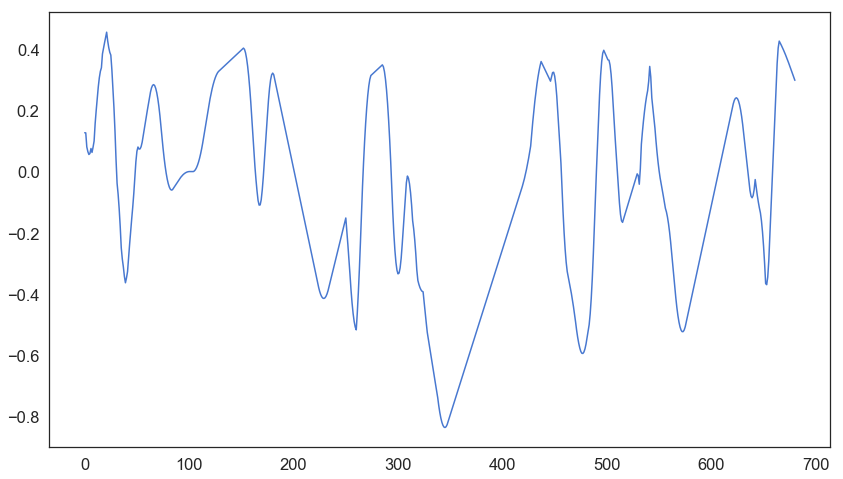

In [22]:
plt.plot(range(len(testingData)), [st[4] for st in testingData])

Now, let's compute the scores for all three baselines on our test data.

<IPython.core.display.Javascript object>


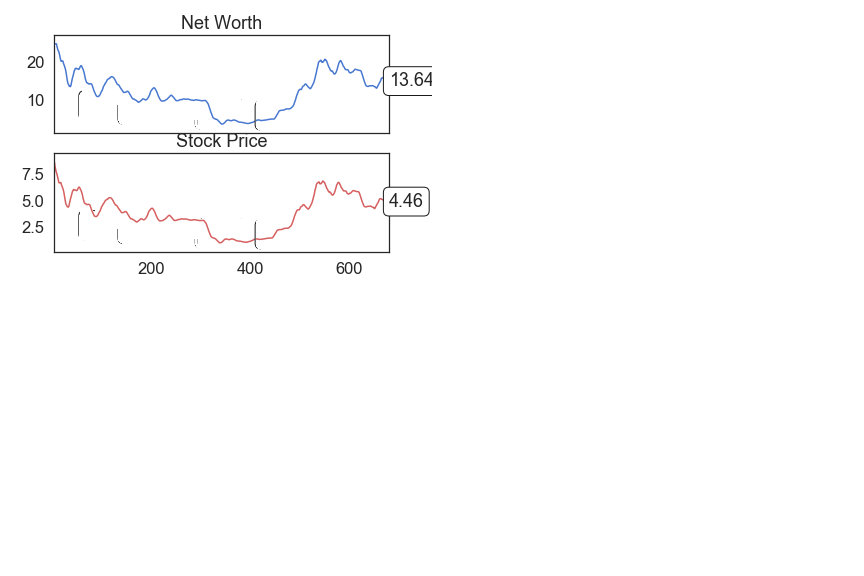

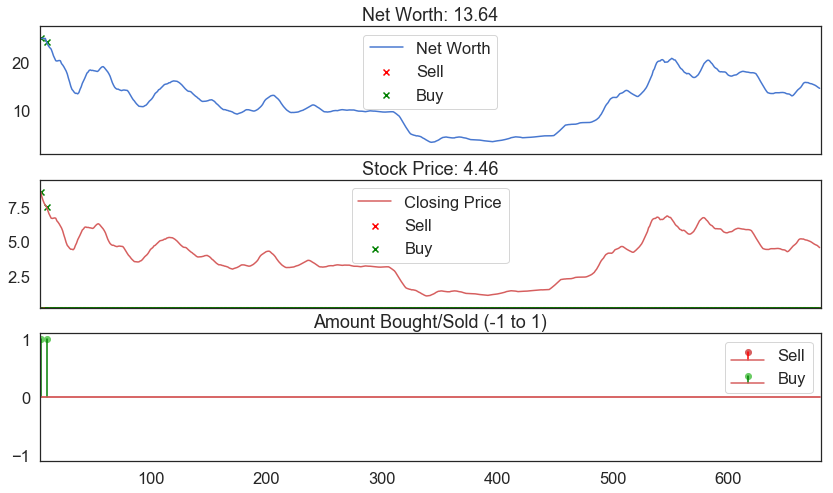

Score for BHODL baseline: 13.637


<IPython.core.display.Javascript object>


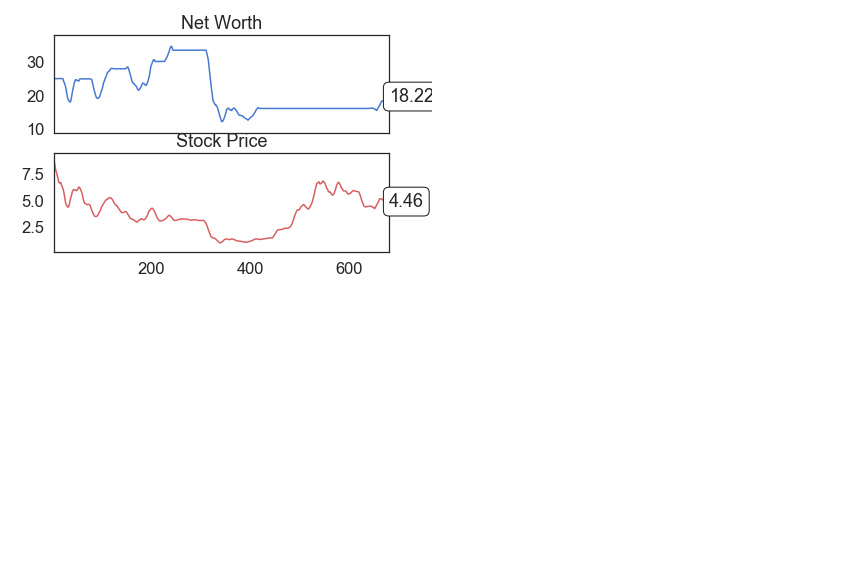

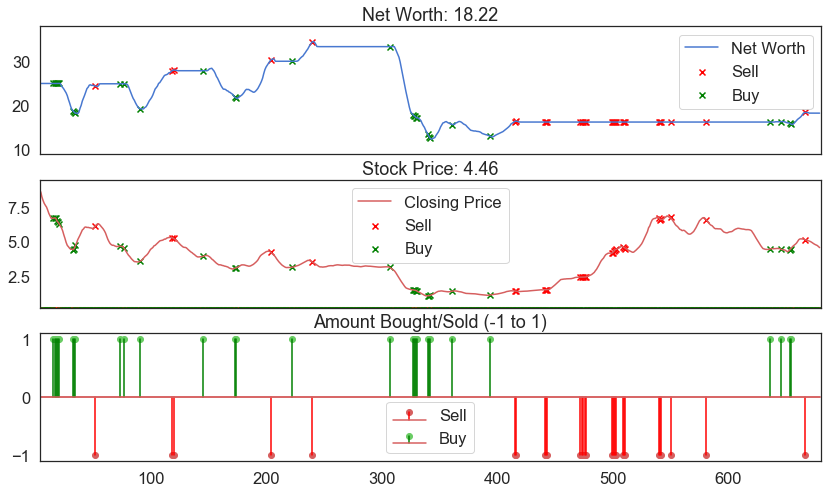

Score for RSI Divergence baseline: 18.218


<IPython.core.display.Javascript object>


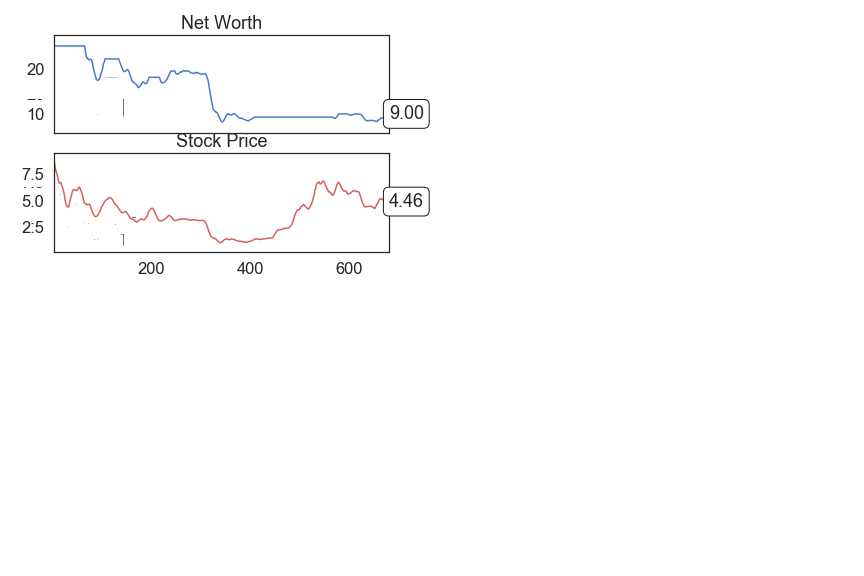

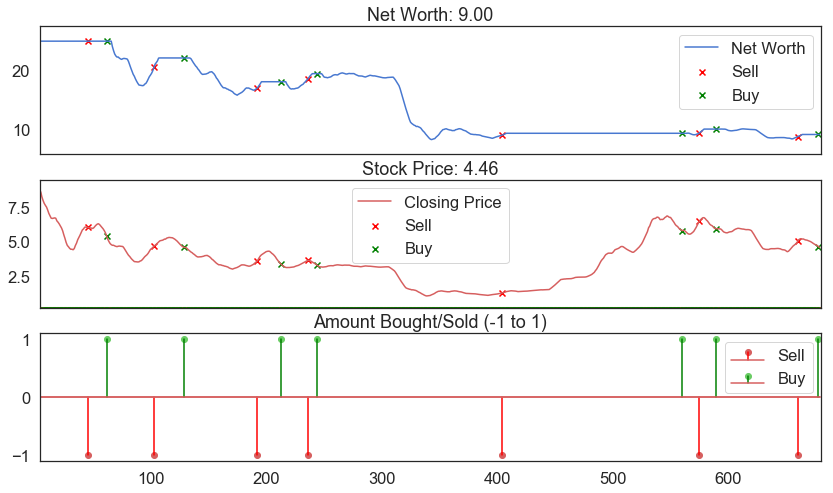

Score for SMA Crossover baseline: 8.996
[13.636905031320481, 18.218336419736207, 8.99636570485667]


In [24]:
test_baselines = Baselines(testingDF, render=False)
test_baseline_scores = test_baselines.run_policies()

print(test_baseline_scores)

Now, run the A2C algorithm for the testing data:

<IPython.core.display.Javascript object>


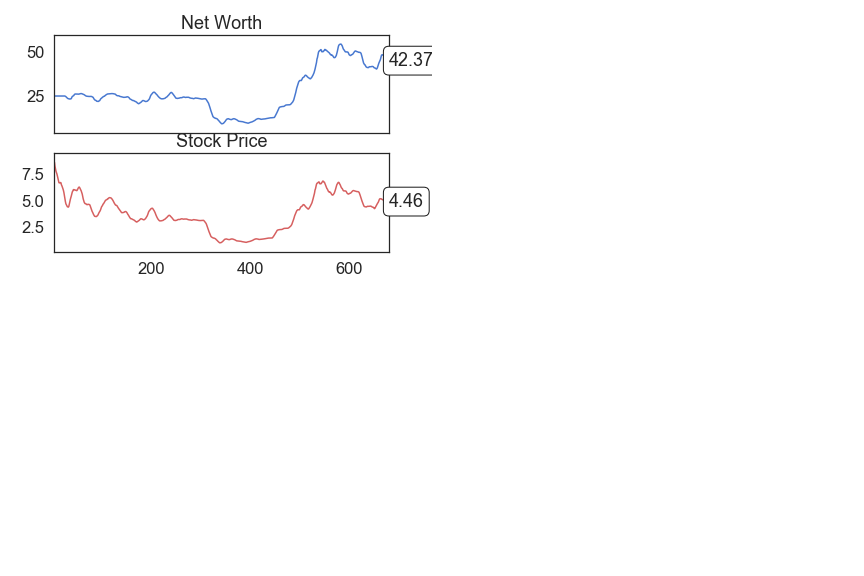

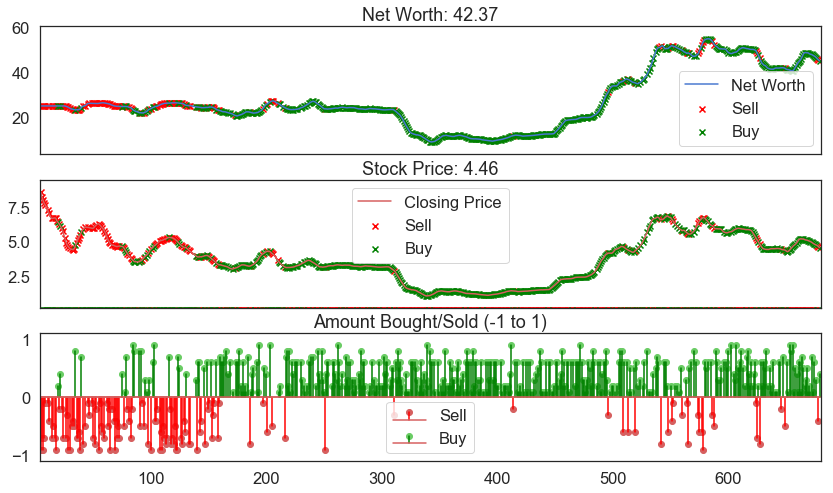

A2C Score: 42.372
A2C - BHODL = 28.735
A2C - RSI Divergence = 24.154
A2C - SMA Crossover = 33.376


In [25]:
# A2C algorithm
a2cEnv = TradingEnv(testingDF, init_invest=INIT_INVEST, is_serial=True)  # For training purposes
done = False

state = a2cEnv.reset()

while not done:
    action, _ = model.predict([state])

    state, _, done, _ = a2cEnv.step(action[0])
    a2cEnv.render()

a2cScore = a2cEnv.get_val()  # The model's score

print("A2C Score: {:.3f}".format(a2cScore))

# Compare that to baselines
print("A2C - BHODL = {:.3f}".format(a2cScore - test_baseline_scores[0]))
print("A2C - RSI Divergence = {:.3f}".format(a2cScore - test_baseline_scores[1]))
print("A2C - SMA Crossover = {:.3f}".format(a2cScore - test_baseline_scores[2]))